# Language Binding
---

**Gregory Farage, Śaunak Sen**    

    gfarage@uthsc.edu / sen@uthsc.edu
    Division of Biostatistics
    Department of Preventive Medicine
    University of Tennessee Health Science Center
    Memphis, TN

The advantages of Julia can be fully appreciated when used exclusively, however, it is reassuring to know that there are multiple ways to incorporate Python and R into your workflow. The purpose of this notebook is for you to see as simple it is to call function or libraries from other programming languages. We show you few examples how to directly call and fully interoperate with R from the Julia language, with the packages `RCall.jl`.


*References for this notebook:*
* [RCall.jl](http://juliainterop.github.io/RCall.jl/stable/)

### Outline of this notebook

- Toy example
- Calling R built-in function
- Calling R hand-written function
- Transfering data between Julia and R 

## Toy example

Let's use the `sum` function as an example to understand how calling mechanisms work.   

The function `sum(x)` can computes the sum of all elements in an array `x` of length $n$:
$$
\mathrm{sum}(x) = \sum_{i=1}^n x_i.
$$

Generate a vector of random numbers

In [1]:
a = rand(10^3);

The expected value is 500, since the vector `a` has a uniform distribution on [0,1) with each entry having a mean of 0.5.

In [2]:
 sum(a)

495.4443639766673

## Calling R built-in `sum` 

While it's true that Julia's package environment is not as extensive as R's, there are ways to bridge the gap between the two languages. One way to do this is by using `RCall`, a package that allows for seamless interoperability between R and Julia. With RCall, you can easily call R functions and pass data between the two languages. Let's take a look at how to use `RCall` to achieve this.

In [3]:
# To use RCall for the first time, one needs to 
# the location of the R home directory.

firstTimeRCall = false # change to `true` if usinng RCall for the first time

if firstTimeRCall
    using Pkg
    my_R_home = "C:/PROGRA~1/R/R-42~1.2" # "/usr/lib/R" # replace example path by your own path from R.home() in R
    ENV["R_HOME"] = my_R_home 
    Pkg.build("RCall")
end     

In [4]:
# In case of package's conflict try to run the following code.

# using Pkg; Pkg.resolve();Pkg.instantiate()

In [5]:
using RCall

We can directly use base R functions and easily pass arguments between R and Julia, as shown in the following example:

In [6]:
# Syntax Option 1
R"sum($a)"

RObject{RealSxp}
[1] 495.4444


In [7]:
# Syntax Option 2
rcall(:sum, a)

RObject{RealSxp}
[1] 495.4444


In [8]:
sum_R = convert(Float64, rcall(:sum, a))

495.4443639766674

## Calling R hand-written function

 We can directly write the R function and wrap it into a julia function.    
In the next example, a small dataset is used, which is based on a genetic study conducted on Arabidopsis thaliana, sourced from [Ågren et. al. (2013) via John Lovell](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3876199/). The phenotype dataset comprises a group of Arabidopsis recombinant inbred lines that were obtained from a cross between two parents hailing from Italy and Sweden. These lines were cultivated in Italy and Sweden over a span of three years, from 2009 to 2011. The phenotype, which is an indicator of fitness, is the average number of seeds per plant for each line. In addition, we possess the genotype data for the FLC (Flowering Time C) locus.

Column names:

- id: ID of RI line (first two are the parents)
- it09: Italy 2009
- it10: Italy 2010
- it11: Italy 2011
- sw09: Sweden 2009
- sw10: Sweden 2010
- sw11: Sweden 2011
- flc: Flowering time locus (C) genotype

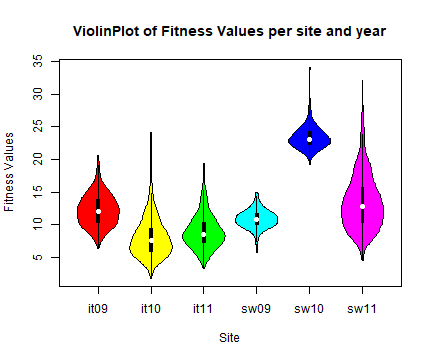

In [17]:
R"""
suppressMessages(library(vioplot)); 
agrenViolinPlot <- function(){
    agrenURL <- "https://raw.githubusercontent.com/sens/smalldata/master/arabidopsis/agren2013.csv"
    agren <- read.csv(agrenURL); 
    agrenFit <- agren[,c(1,2,3,4,5,6)]
    vioplot(agrenFit, 
            names=names(agrenFit), 
            main = "ViolinPlot of Fitness Values per site and year", 
            xlab ="Site", 
            ylab =  "Fitness Values",
            col = rainbow(6))
}
"""
R"agrenViolinPlot"();

## Transfering data between Julia and R 

To transfer data between both languages, `RCall.jl` provides two macros: `@rput` and `@rget`.

* The `@rput` macro is used to transfer data from Julia to R. 
* The `@rget` macro is used to transfer data from R to Julia. 

Let transfer the `agrenfit` dataframe from the R code and let's plot its violin plot from Julia. 

R code generating `agrenfit`:

In [32]:
R"""
agrenURL <- "https://raw.githubusercontent.com/sens/smalldata/master/arabidopsis/agren2013.csv"
agren <- read.csv(agrenURL); 
agrenFit <- agren[,c(1,2,3,4,5,6)];
""";

Transfer `agrenfit`from R to Julia:

In [33]:
@rget agrenFit;

In [35]:
first(agrenFit)

Row,it09,it10,it11,sw09,sw10,sw11
,Float64?,Float64?,Float64,Float64?,Float64?,Float64
1,19.7616,24.1761,15.6778,5.66443,21.4804,4.47778


In [36]:
using StatsPlots

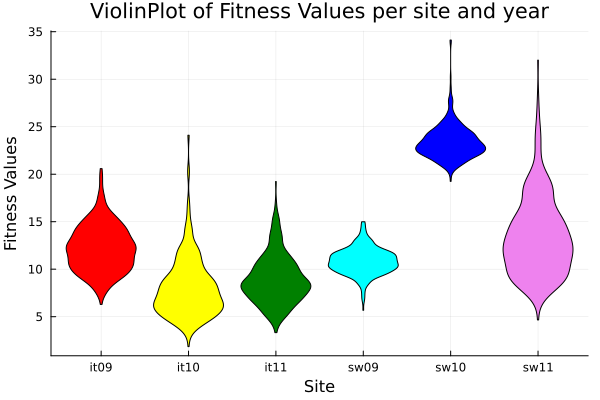

In [69]:
data = map(i -> skipmissing(agrenFit[:,i]), 1:size(agrenFit, 2))
violin(
    data,
    title = "ViolinPlot of Fitness Values per site and year", 
    xlabel = "Site", 
    ylabel = "Fitness Values",
    xticks = (1:6, names(agrenFit)),
    color=[:red :yellow :green :cyan :blue :violet],
    legend = false,
)

We can even apply the R `summary()` function on our Julia dataframes:

In [12]:
rcall(:summary, agren)

RObject{StrSxp}
      it09             it10             it11             sw09       
 Min.   : 6.288   Min.   : 1.774   Min.   : 3.239   Min.   : 5.664  
 1st Qu.:10.366   1st Qu.: 5.886   1st Qu.: 7.136   1st Qu.: 9.992  
 Median :12.058   Median : 7.522   Median : 8.524   Median :10.834  
 Mean   :12.222   Mean   : 8.053   Mean   : 8.910   Mean   :10.855  
 3rd Qu.:13.872   3rd Qu.: 9.457   3rd Qu.:10.325   3rd Qu.:11.713  
 Max.   :20.592   Max.   :24.176   Max.   :19.311   Max.   :15.001  
      sw10            sw11              id             flc       
 Min.   :19.23   Min.   : 4.478   Min.   :  1.0   Min.   :1.000  
 1st Qu.:22.26   1st Qu.:10.303   1st Qu.:158.8   1st Qu.:1.000  
 Median :23.08   Median :12.760   Median :316.5   Median :2.000  
 Mean   :23.37   Mean   :13.481   Mean   :326.5   Mean   :1.538  
 3rd Qu.:24.28   3rd Qu.:15.703   3rd Qu.:491.0   3rd Qu.:2.000  
 Max.   :34.13   Max.   :32.189   Max.   :700.0   Max.   :2.000  


In [13]:
versioninfo()

Julia Version 1.8.5
Commit 17cfb8e65e (2023-01-08 06:45 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 8 × 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, tigerlake)
  Threads: 1 on 8 virtual cores


## Summary

* This solution enables users to combine Julia and R in their workflows for data analysis and statistical computing.
* Sharing data structures and objects is possible.
* Julia's users can access R's broad range of statistical and data analysis packages, while still benefiting from Julia's performance and flexibility.
* RCall.jl eliminates the need for constantly switching between Julia and R, streamlining their workflow and enhancing their productivity.
